<a href="https://colab.research.google.com/github/sriksmachi/sriksml/blob/main/reinforcement-learning/ppo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proximal Policy Optimization.

PPO is a policy graident method that can be used for environments with both discrete and continuous action spaces. It is an on-policy learning algorithm, which means that the policy is updating more frequently on same episode.

It uses an actor critic method.
- Actor is responsible for mapping observations to actions. This is similar to the learning model in REINFORCE algorithm.
- Critic is responsible for computing the estimate of the value function for the given observation. The estimate of the value function is used to identify how good the action was.
The actor is fine tuned using stochastic gradient ascent to learn to predict good actions eventually.

This is different from traditional policy gradient methods because, traditional Policy gradient methods having many drawbacks.
- Sample inefficiency: Traditional policy gradients make policy updates after every episode, the trajectories before the policy update are discarded making the whole approach sample inefficient.
- Inefficient policy updates: Since the policy update happens too frequently with only the latest trajectories, there is a chance for the model to get stuck in local minima, or deviate too much due to large (or uncontrolled) policy updates.
- High variance: In vanilla policy gradients like REINFORCE, expected rewards are calculated using the trajectories. Since the trajectories and expected rewards deviate a lot from each other, the gradient updates and rewards become noisy introducing high variance.
- Zero reward: If the expected reward of a trajectory is zero, the policy gradient algorithm cannot learn anything.
- Slow learning process: Due to the dependency on trajectories that deviate a lot from each other, the learning process in REINFORCE is too slow. They take a lot of time to converge.

PPO overcomes these problems by creating a simple, sample efficient, generalized variant of policy graident methods. Here are few key differentiators.

- Conservative Policy updates : To avoid larger changes to the policy, PPO uses a clipped objective function. The clipped function uses probability ratio (same as TRPO) to identify the magnitude of update. The update is only performed if it falls within the bounds of the clipped function.
- Data efficiency : PPO also alternates between sampling data from policy and optimization. The optimization is performed using several epochs of training from sampled data.

## How PPO training works

There are a few terms that you need to understand before learning how PPO works.

|||
|-|-|
| Trajectory | A trajectory is a sequence of state, action, reward pairs that are part of one episode. For example, in the game of pacman every state, action and reward you get until you will or loose is called a trajectory.
| Baseline | Since the cumulative reward suffer from high variance, the idea is to substract "baseline" from the cumulative reward. The baseline can be any term - Q-Value, Advantage Value or Temporal difference. |
| Advantage | Advantage value determines how good an action is in a given state compared to the average value. It is computed by substracting the value of the state from Q-value (state, action).
| Probability ratio | Probability ratio is the ration of log probabilities generated by new policy to the log probabilities generated by new policy.|

### Algorithm

The below algorithm represents PPO with Clipped surrogate objective function.

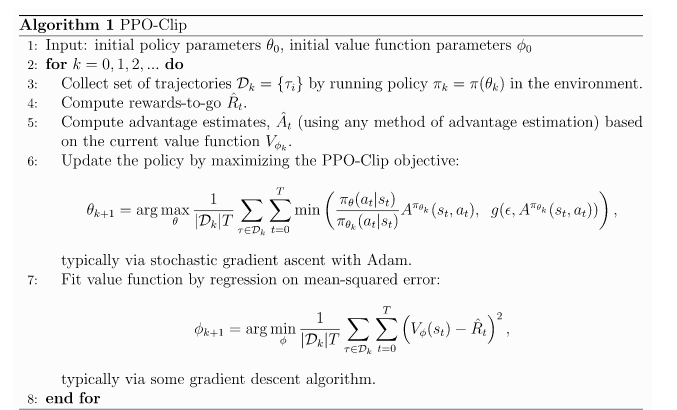





### Steps involved in PPO with clipped objective function

1. Initially Critic Neural Network and Actor neural network are initialized randomly.
2. For a fixed number of episodes
    
    2.1 The actor model takes current state (observation) as input and predicts the action to be taken, value of the action and log probabilities. The environment returns the next state, reward, doneness and any addition info for the action taken by the actor. This constitutes one time step in training process.
    
    2.2 The observation, action, log probabilities, value of the action, reward shared by the environment, and doneness value is stored in memory.

    2.3 Learning process can be configured for a fixed number of time steps, the below steps explain what happens during learning process.        
        2.3.1 Compute the advangate estimates using rewards, values from memory.
        2.3.2 Compute Actor loss using clipped objective function.
        2.3.3 Compute Critic loss, MSE of actual estimates and expected estimates.
        2.3.4 Apply the policy gradients to actor, critic model.

In [ ]:
%pip install gym==0.22  > /dev/null 2>&1
%pip install tensorflow_probability  > /dev/null 2>&1
%pip install tensorflow  > /dev/null 2>&1
%pip install pygame  > /dev/null 2>&1

In [ ]:
import tensorflow as tf
import numpy as np
import gym
import tensorflow_probability as tfp
import tensorflow.keras.losses as kls
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

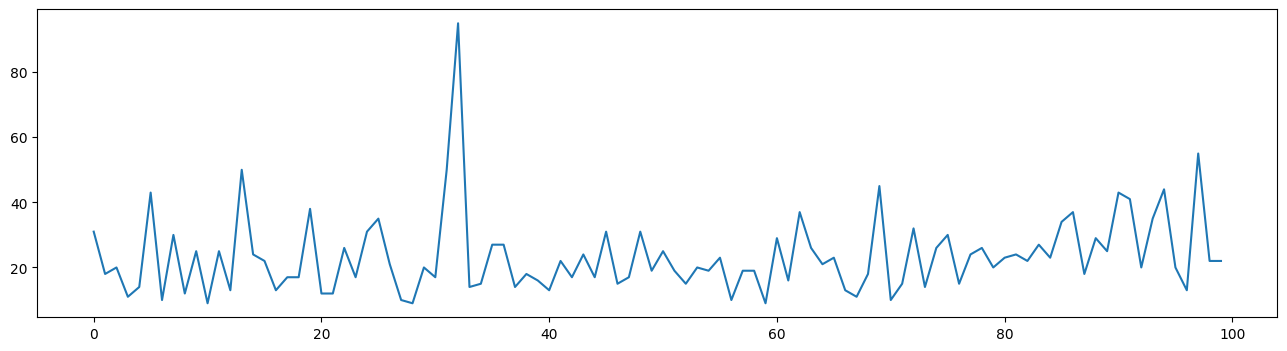

In [ ]:
# Lets create a baseine pendulum environment with random agent and run it for 100 episodes
env = gym.make('CartPole-v1')
total_rewards = []
for i in range(100):
  env.reset()
  rewards = []
  terminal = False
  while not terminal:
    action = env.action_space.sample()
    observation, reward, terminal, info = env.step(action)
    rewards.append(reward)
  total_rewards.append(np.sum(rewards))
plt.figure(0, figsize=(16,4))
plt.plot(total_rewards)

## PPO Memory

The below class acts as a memory buffer for storing transitions - state, action, log probabilities, values, reward and doneess. It is also responsible for generating batches from the stored transitions. The batches are used for training the Actor, Critic models.

In [ ]:
import numpy as np

class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
            np.array(self.actions),\
            np.array(self.probs),\
            np.array(self.vals),\
            np.array(self.rewards),\
            np.array(self.dones),\
            batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []


## Actor Model

The actor model is responsible for predicting the action probabilities for a given state.

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense

class actor(keras.Model):
    def __init__(self, n_actions, fc1_dims=256, fc2_dims=256):
        super(actor, self).__init__()
        self.fc1 = Dense(fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        self.fc3 = Dense(n_actions, activation='softmax')

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

## Critic Model

The critic model is responsible for estimating the value function - V(s).

In [ ]:
class critic(tf.keras.Model):
  '''
  critic network outputs the Q value, the estimate the discounted reward from the current point
  '''
  def __init__(self, fc1_dims=256, fc2_dims=256):
    super(critic, self).__init__()
    self.fc1 = tf.keras.layers.Dense(fc1_dims,activation='relu')
    self.fc2 = tf.keras.layers.Dense(fc2_dims,activation='relu')
    self.a = tf.keras.layers.Dense(1,activation=None)

  def call(self, input_data):
    x = self.fc1(input_data)
    x = self.fc2(x)
    a = self.a(x)
    return a

## Agent

The agent is where all the magic happens, it has the following key methods.

- Choose Action: For a given state, the choose action method first predicts the action probabilities. From the out, an action is sampled which becomes the input for the critic function to predict the Value function.
- Actor Loss: To compute the actor loss we need 3 key ingredients - Advantages, New & Old log probabilities. An advantage is defined using the below equation.

$A(s_t, a_t) = Q_w(s_t, a_t) - V_v(S_t)$. -------- (1)

Since the critic network only computes V value, the equation can be re-written using bellman's equation as

$ Q(s_t, a_t) = E[r_{t+1} + \Upsilon * V_v (S_{t+1}) - V_v (S_{t})]$ -------(2)

Rewriting equation (2) in (1)

$A(s_t, a_t) = r_{t+1} + \Upsilon * V_v (S_{t+1}) - V_v (S_{t})$.

Using the above equation we can use the V value predicted by critic network to compute the advantages. Advantages, log probabilities are used to compute actor loss using the following equation. The equation is written using terms instead of actual symbols to make it simple to explain.

$ probabilityRatio (r_t(θ)) = E[newLogProbabilities/oldLogProbabilities] $

The above equation calculates how large the update is on the new policy, compared to old policy. Since large updates can create a swing on the policy, the updates are clipped using the below equation

$ clippedProbabilityRatio = clip(probabilityRatio, 1-ϵ, 1+ϵ), where, ϵ = 0.2 $

The final clipped objective function looks like

$ actorloss = -min(probabilityRatio * A, clippedProbabilityRation * A) $

- Critic Loss: Critic loss is defined as the ability of the model to predict the value of the state.  Returns is defined by the below equation

$V(s_t) = r_{t+1} + \Upsilon * V_v (S_{t+1}) $

Hence the critic loss is nothing but Mean squared error between the predicted critical value and the actual value from the trajectory.

- Learning Process: The learning process has 3 key steps
1. Compute advantages for all the experiences stored in the memory.
2. Generate batches
3. For each batch

    3.1 Compute the new probabilities for a given state using actor network

    3.2 Compute the new value of the state using the critic network

    3.3 Compute the actor loss and critic loss

    3.4 Update the model parameters.

The above steps 1-3 are repeated for fixed number of Epochs, at the end of all epochs the memory is cleared to collect fresh experiences.


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp


class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003,
                 gae_lambda=0.95, policy_clip=0.2, batch_size=64,
                 n_epochs=10, chkpt_dir='models/'):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        self.chkpt_dir = chkpt_dir

        self.actor = actor(n_actions)
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic = critic()
        self.critic.compile(optimizer=Adam(learning_rate=alpha))
        self.memory = PPOMemory(batch_size)

    def store_transition(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save(self.chkpt_dir + 'actor')
        self.critic.save(self.chkpt_dir + 'critic')

    def load_models(self):
        print('... loading models ...')
        self.actor = keras.models.load_model(self.chkpt_dir + 'actor')
        self.critic = keras.models.load_model(self.chkpt_dir + 'critic')

    def choose_action(self, observation):
        state = tf.convert_to_tensor([observation])

        probs = self.actor(state)
        dist = tfp.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        value = self.critic(state)

        action = action.numpy()[0]
        value = value.numpy()[0]
        log_prob = log_prob.numpy()[0]

        return action, log_prob, value

    def compute_actor_loss(self, new_probs, old_probs, advantage, batch):
        # Log form of how much the policy has changed
        prob_ratio = tf.math.exp(new_probs - old_probs)
        weighted_probs = advantage[batch] * prob_ratio
        clipped_probs = tf.clip_by_value(prob_ratio, 1-self.policy_clip, 1+self.policy_clip)
        weighted_clipped_probs = clipped_probs * advantage[batch]
        actor_loss = -tf.math.minimum(weighted_probs, weighted_clipped_probs)
        return tf.math.reduce_mean(actor_loss)

    def compute_critic_loss(self, critic_value, advantage, values, batch):
        # advantage is defined as Q(s,a)-V(s) now by adding V(s) to this
        # returns becomes the value of the action taken by our policy.
        returns = advantage[batch] + values[batch]
        # critic value should equal the value of the action that's chosen according to that policy
        # But since we are choosing the action according to our policy, the state value (acc. to the policy)
        # should equal the value of the action that's chosen according to that policy (in the trajectory)
        return keras.losses.MSE(critic_value, returns)

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
                reward_arr, dones_arr, batches = \
                self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            # calculating advangates using gae -> generalized advantage estimate
            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1] * (1-int(dones_arr[k])) - values[k])
                    # Lambda λ is a smoothing parameter used for reducing the variance in training which makes it more stable.
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t

            for batch in batches:
                with tf.GradientTape(persistent=True) as tape:
                    states = tf.convert_to_tensor(state_arr[batch])
                    old_probs = tf.convert_to_tensor(old_prob_arr[batch])
                    actions = tf.convert_to_tensor(action_arr[batch])

                    probs = self.actor(states)
                    dist = tfp.distributions.Categorical(probs)
                    new_probs = dist.log_prob(actions)
                    critic_value = self.critic(states)
                    critic_value = tf.squeeze(critic_value, 1)

                    actor_loss = self.compute_actor_loss(new_probs, old_probs, advantage, batch)
                    critic_loss = self.compute_critic_loss(critic_value, advantage, values, batch)

                actor_params = self.actor.trainable_variables
                actor_grads = tape.gradient(actor_loss, actor_params)
                critic_params = self.critic.trainable_variables
                critic_grads = tape.gradient(critic_loss, critic_params)
                self.actor.optimizer.apply_gradients(
                        zip(actor_grads, actor_params))
                self.critic.optimizer.apply_gradients(
                        zip(critic_grads, critic_params))

        self.memory.clear_memory()


## Experiments

In this section we run the experience for fixed steps. The learning processes gets kicked in for a fixed number of steps. At the end of each step we compute the score (in case of Cartpole this is how long we were able to hold the pole in one episode), and average score for last 100 steps.

In [ ]:
steps = 300
N = 20
batch_size = 5
n_epochs = 4
alpha = 0.0003
env = env = gym.make('CartPole-v0')
learn_iters = 0
avg_score = 0
n_steps = 0
score_history = []
avg_score_history = []
best_score = env.reward_range[0]
rl_agent = Agent(n_actions=env.action_space.n, batch_size=batch_size, alpha=alpha, n_epochs = n_epochs, input_dims=env.observation_space.shape)
for step in range(steps):
  state = env.reset()
  done = False
  score = 0
  while not done:
    action, prob, value =  rl_agent.choose_action(state)
    next_state, reward, done, _ = env.step(action)
    n_steps += 1
    score += reward
    rl_agent.store_transition(state, action, prob, value, reward, done)
    if n_steps % N == 0:
      rl_agent.learn()
      learn_iters += 1
    state = next_state
  score_history.append(score)
  avg_score = np.mean(score_history[-100:])
  avg_score_history.append(avg_score)
  if avg_score > best_score:
    best_score = avg_score
    rl_agent.save_models()
  tf.summary.scalar('reward summary', data=avg_score, step=step)
  print('episode', step, 'score %.1f' % score, 'avg score %.1f' % avg_score, 'time_steps', n_steps, 'learning_steps', learn_iters)



... saving models ...
episode 0 score 12.0 avg score 12.0 time_steps 12 learning_steps 0
episode 1 score 12.0 avg score 12.0 time_steps 24 learning_steps 1
episode 2 score 9.0 avg score 11.0 time_steps 33 learning_steps 1
... saving models ...
episode 3 score 18.0 avg score 12.8 time_steps 51 learning_steps 2
... saving models ...
episode 4 score 19.0 avg score 14.0 time_steps 70 learning_steps 3
episode 5 score 13.0 avg score 13.8 time_steps 83 learning_steps 4
episode 6 score 12.0 avg score 13.6 time_steps 95 learning_steps 4
episode 7 score 13.0 avg score 13.5 time_steps 108 learning_steps 5
episode 8 score 10.0 avg score 13.1 time_steps 118 learning_steps 5
episode 9 score 18.0 avg score 13.6 time_steps 136 learning_steps 6
... saving models ...
episode 10 score 29.0 avg score 15.0 time_steps 165 learning_steps 8
... saving models ...
episode 11 score 16.0 avg score 15.1 time_steps 181 learning_steps 9
episode 12 score 12.0 avg score 14.8 time_steps 193 learning_steps 9
episode 13 

## Analysis

Here we plot the rewards the agent accumulated per episode, and as well the avergae of the rewards for last 100 episodes. If you run this for enough number of episodes (say 500), you will notice that the average reaches the maximum value for episode which is 200 for Cartpole V0

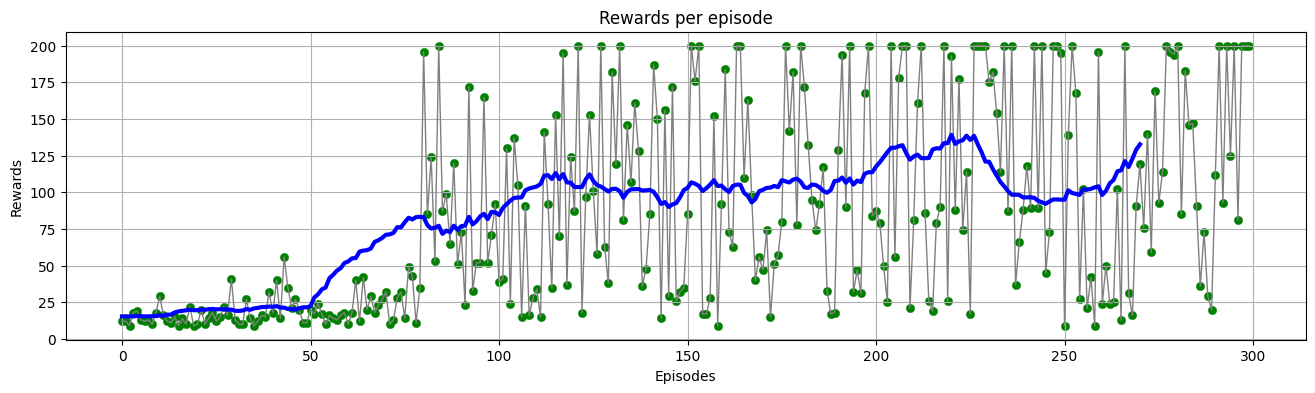

In [ ]:
x_axis = np.asarray(range(0, steps))
y_axis = np.asarray(score_history)
plt.figure(0, figsize=(16,4))
plt.title('Rewards per episode')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.plot(score_history, color='gray' , linewidth=1)
plt.plot(avg_score_history, color='blue', linewidth=3)
plt.scatter(x_axis, y_axis, color='green' , linewidth=0.3)
plt.grid()
plt.show()

## Evaluation

We may now use the agent for maximizing the rewards in production. The below code lets the agent act in the environment and also render the environment.
At the end of the episode the total reward is shown, this should be near the average value. For more episodes, the agent should consistently earn 200 rewards.

In [ ]:

# Configuration the image rendering in colab

# Taken from
# https://towardsdatascience.com/rendering-openai-gym-envs-on-binder-and-google-colab-536f99391cc7

!apt-get install -y xvfb x11-utils &> /dev/null

!pip install pyvirtualdisplay==0.2.* \
             PyOpenGL==3.1.* \
             PyOpenGL-accelerate==3.1.* &> /dev/null

!pip install gym[box2d]==0.17.* &> /dev/null

# Taken from https://github.com/actions/virtual-environments/issues/214
!sudo apt-get update  &> /dev/null
!sudo apt-get install xvfb --fix-missing &> /dev/null

import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
_ = _display.start()

!echo $DISPLAY # sanity checking: should be set to some value (e.g. 1005)

from IPython import display

:1001


Reward: 173.0


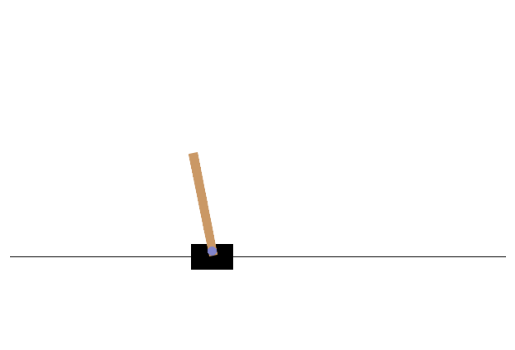

In [ ]:
env = gym.make('CartPole-v0')
state = env.reset()
rewards = []
img = plt.imshow(env.render(mode='rgb_array'))
for t in range(2000):
  action, _, _ = rl_agent.choose_action(state)
  img.set_data(env.render(mode='rgb_array'))
  plt.axis('off')
  display.display(plt.gcf())
  display.clear_output(wait=True)
  state, reward, done, _ = env.step(action)
  rewards.append(reward)
  if done:
      print("Reward:", np.sum(rewards))
      break
env.close()


## Summary

In summary Proximal Policy Optimization (PPO) is a very popular algorithm that is used in a variety of use cases like training Chat GPT. PPO has been used to train agents to play complex video games such as Dota 2 and Starcraft 2.  It is simple to implement and solves many problems associated with vanilla policy gradient like high variance. However, it has few limitations.

- Since PPO uses the same policy for both phases, it can suffer from premature convergence or local optima. To mitigate this issue, PPO relies on entropy regularization, which encourages the policy to explore more diverse actions. However, this can also reduce the policy's accuracy and consistency
- The second limitation is its sensitivity to the clipping ration. If the clipping ration is too small, the model's learning will be conservative and slow. If the clipping ration is too big the model's learning will be too aggresive.
- PPO often discards data collected during earlier interactions with the environment as new policy updates are computed. This means that the algorithm does not fully reuse the collected data, and a substantial amount of experience may be wasted.
- It also suffers from high variance because the same policy is used to collect the experiences. If the policy updates are larger the data collected can be completely different than the ones collected.

Nonetheless, the algorithm is used in variety of problems, there is still in active research to solve the limitations of PPO.